In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../data/preprocessed/full_dataset.csv').rename(columns={'POO_LONGITUDE': 'longitude', 'POO_LATITUDE': 'latitude'})

C:\Users\benja\AppData\Local\Temp\ipykernel_85980\42329501.py:1: DtypeWarning: Columns (48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/preprocessed/full_dataset.csv').rename(columns={'POO_LONGITUDE': 'longitude', 'POO_LATITUDE': 'latitude'})


In [3]:
resources = pd.read_csv('../data/raw/resources.csv').groupby('INC209R_IDENTIFIER')['RESOURCE_PERSONNEL'].sum()

In [4]:
df = df[['report_id', 'fire_id', 'area', 'date', 'longitude', 'latitude', 'REPORT_FROM_DATE']].merge(resources, left_on='report_id', right_on='INC209R_IDENTIFIER', how='inner')

In [5]:
df.rename(columns={"RESOURCE_PERSONNEL": "total_crews_sent", "REPORT_FROM_DATE": "from_date"}, inplace=True)

In [6]:
df.isna().mean()

report_id           0.000000
fire_id             0.000000
area                0.000104
date                0.000000
longitude           0.000286
latitude            0.000286
from_date           0.000000
total_crews_sent    0.000000
dtype: float64

In [7]:
df.to_csv('data/wildfire_suppression.csv', index=False)

In [8]:
df.head()

,report_id,fire_id,area,date,longitude,latitude,from_date,total_crews_sent
0,2714023,2714022,150.0,2015-05-06 10:15:00,-71.251944,43.781111,2015-05-05 09:30:00,45.0
1,2714037,2714022,275.0,2015-05-08 00:30:00,-71.251944,43.781111,2015-05-07 11:00:00,45.0
2,2714050,2714022,275.0,2015-05-09 00:30:00,-71.251944,43.781111,2015-05-08 11:00:00,33.0
3,2714066,2714022,275.0,2015-05-10 13:00:00,-71.251944,43.781111,2015-05-09 15:00:00,0.0
4,2714082,2714081,205.0,2015-05-07 07:15:00,-67.012500,44.791667,2015-05-06 20:30:00,21.0


In [9]:
sent_troups = df.groupby('fire_id')['total_crews_sent'].sum()

In [10]:
df['fire_total_crews_sent'] = sent_troups[df['fire_id']].values

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
study_df = df.copy()

In [13]:
non_zeros = study_df[(study_df!=0).all(axis=1)].dropna()

In [14]:
from scipy.stats import linregress
import numpy as np
plt.figure(figsize=(10, 6))

sns.scatterplot(data=df, x='area', y='total_fire_crews')
plt.xscale('log')
plt.yscale('log')
plt.title('Scatter Plot of Area vs Total Fire Crews with Corrected Regression Line')
plt.xlabel('Area (log scale)')
plt.ylabel('Total Fire Crews (log scale)')

study_df = non_zeros#df[['area', 'total_fire_crews']].dropna()
log_area = np.log(study_df['area'])
log_total_fire_crews = np.log(study_df['fire_total_crews_sent'])
slope, intercept, r_value, p_value, std_err = linregress(log_area, log_total_fire_crews)

regression_line = np.exp(intercept) * (study_df['area'])**slope

# Plotting the regression line on the original scale
plt.plot(study_df['area'], regression_line, color='red', label=f'Slope: {slope:.4f}, Intercept: {np.exp(intercept):.4f}')
plt.legend()
plt.show()

ValueError: Could not interpret value `total_fire_crews` for parameter `y`

<Figure size 1000x600 with 0 Axes>

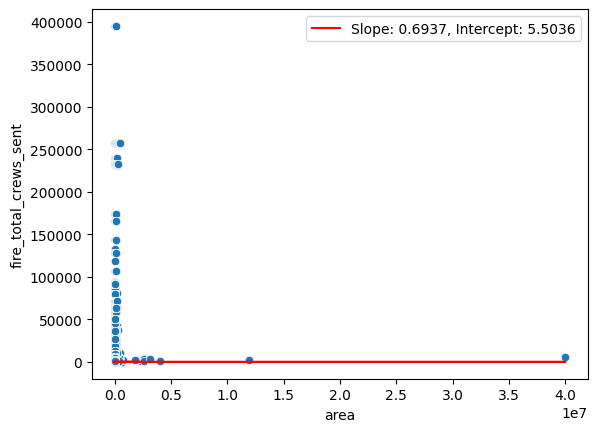

In [ ]:
regression_line = np.log(np.exp(intercept) * (1+study_df['area'])**slope)

sns.scatterplot(data=df, x='area', y='fire_total_crews_sent')
plt.plot(1+study_df['area'], regression_line, color='red', label=f'Slope: {slope:.4f}, Intercept: {np.exp(intercept):.4f}')
plt.legend()
plt.show()

In [ ]:
from scipy.stats import linregress
import numpy as np

study_df = non_zeros.copy()
log_area = np.log(1+study_df['area'])
log_total_fire_crews = np.log(1+study_df['total_fire_crews'])
slope, intercept, r_value, p_value, std_err = linregress(log_area, log_total_fire_crews)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from scipy.stats import linregress


log_area = np.log(study_df['area'])
log_total_fire_crews = np.log(study_df['total_fire_crews'])
slope, intercept, r_value, p_value, std_err = linregress(log_area, log_total_fire_crews)
regression_line = np.exp(intercept) * (study_df['area'])**slope
fig = px.scatter(study_df, x='area', y='total_fire_crews', log_x=True, log_y=True,
                 labels={'area': 'Area', 'total_fire_crews': 'Total Fire Crews'},
                 title='Scatter Plot of Area vs Total Fire Crews with Regression Line')

fig.add_trace(go.Scatter(x=study_df['area'], y=regression_line, mode='lines',
                         name=f'Slope: {slope:.4f}\nIntercept: {np.exp(intercept):.4f}',
                         line=dict(color='red')))

fig.update_layout(legend=dict(y=0.5, font_size=12),
                  margin=dict(l=40, r=40, t=40, b=40))

# Display the plot
fig.show()


In [17]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from scipy.stats import linregress
target = 'total_crews_sent'

study_df = df.sort_values('date').groupby('fire_id').agg({'area': 'first', target: 'max'}).dropna()
study_df = study_df[(study_df!=0).all(axis=1)]
log_area = np.log(study_df['area'])
log_target = np.log(study_df[target])
slope, intercept, r_value, p_value, std_err = linregress(log_area, log_target)
regression_line = np.exp(intercept) * (study_df['area'])**slope
fig = px.scatter(study_df, x='area', y=target, log_x=True, log_y=True,
                 labels={'area': 'Area', target: target},
                 title=f'Maximum reported amount of crew sent vs first report area')

fig.add_trace(go.Scatter(x=study_df['area'], y=regression_line, mode='lines',
                         name=f'Slope: {slope:.4f}\nIntercept: {np.exp(intercept):.4f}',
                         line=dict(color='red')))

fig.update_layout(legend=dict(y=0.5, font_size=12),
                  margin=dict(l=40, r=40, t=40, b=40))

fig.show()


In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from scipy.stats import linregress
target = 'fire_total_crews_sent'

study_df = df.sort_values('date').groupby('fire_id').first()[['area', target]].dropna()
study_df = study_df[(study_df!=0).all(axis=1)]
log_area = np.log(study_df['area'])
log_target = np.log(study_df[target])
slope, intercept, r_value, p_value, std_err = linregress(log_area, log_target)
regression_line = np.exp(intercept) * (study_df['area'])**slope
fig = px.scatter(study_df, x='area', y=target, log_x=True, log_y=True,
                 labels={'area': 'Area', target: target},
                 title=f'Scatter Plot of initial Area vs total number of crews sent on the fire')

fig.add_trace(go.Scatter(x=study_df['area'], y=regression_line, mode='lines',
                         name=f'Slope: {slope:.4f}\nIntercept: {np.exp(intercept):.4f}',
                         line=dict(color='red')))

fig.update_layout(legend=dict(y=0.5, font_size=12),
                  margin=dict(l=40, r=40, t=40, b=40))

fig.show()


In [207]:
r_value

0.3451454161394206

In [210]:
p_value

1.6943865805654987e-161